This example converts a Sacc1 format file into Sacc2 format,
adding data points one by one

In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sacc
import sacc2

In [3]:
S = sacc.SACC.loadFromHDF('./example-txpipe-sacc1.sacc')

/usr/local/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [4]:
# We will make this new sacc2 format data set
S2 = sacc2.Sacc()

# Converting tracers
for T in S.tracers:
    # The sacc1 format files have the confusing bytes/str HDF5 issue.
    # In this case the names have form "b'name'" where name is the actual
    # name we want.  This is due to confusion somewhere between TXPipe and
    # Sacc1
    name = T.name[2:-1]
    z = T.z
    Nz = T.Nz
    S2.add_tracer('NZ', name, z, Nz)

# Translation of type names into spectrum names
types = {
    ('E','E'): sacc2.known_types.galaxy_shear_ee,
    ('B','B'): sacc2.known_types.galaxy_shear_bb,
    ('E','B'): sacc2.known_types.galaxy_shear_eb,
    ('P','P'): sacc2.known_types.galaxy_density_cl,
    ('P','E'): sacc2.known_types.ggl_E,
    ('P','B'): sacc2.known_types.ggl_B,
}

# The source names to pick out
sources = {
    'E' : 'LSST source_{}',
    'B' : 'LSST source_{}',
    'P' : 'LSST lens_{}',
}

# Loop through all the data points
n = len(S.binning.binar)
for i in range(n):
    # Pull out this row and value
    value = S.mean.vector[i]
    row = S.binning.binar[i]
    
    # Again deal with bytes/str issue
    Q1 = row['Q1'].tostring().decode('ascii')
    Q2 = row['Q2'].tostring().decode('ascii')
    data_type = types[(Q1, Q2)]
    
    # bin name
    bin1 = row['T1']
    bin2 = row['T2']
    
    # Sources are the other way around in this file, again
    # due to an error somewhere  in TXPipe.  So we construct
    # the names by flipping 1,2
    tracer1 = sources[Q2].format(bin1)
    tracer2 = sources[Q1].format(bin2)
    tracers = (tracer1, tracer2)

    ell = row['ls']
    
    # This is a helper method specifically for C_ell data.
    # It is a call to a more basic underlying method.
    S2.add_ell_cl(data_type, tracer1, tracer2, ell, value)



In [5]:
# Write this to file
S2.save_fits('converted.sacc', overwrite=True)


In [6]:
# Check it can be loaded back again
S3 = sacc2.Sacc.load_fits("converted.sacc")


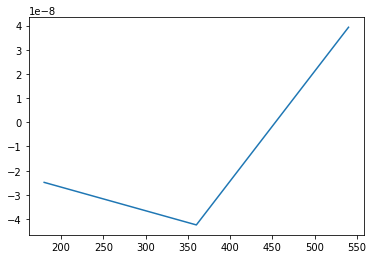

In [7]:
# Plot a single bin pair.
# Again, this is a helper method
ell, cl = S3.get_ell_cl(sacc2.known_types.galaxy_shear_ee, 'LSST source_1', 'LSST source_0')
plot(ell, cl)